In [1]:
%load_ext autoreload
%autoreload 2

from cache import *
from costs import *
from features import *
from helpers import *
from evaluate import *
from validate import *
from implementations import *

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import csv
import warnings
warnings.filterwarnings('ignore')

# Tutorial

Here we will see how to run a basic model and how to do some grid search on the model's parameter.

First, we define the directories path. You can specifiy if you want to load a sub sample of the data set or the full dataset by changing the `SUB_SAMPLE` constant to `True` or `False`:

In [2]:
SUB_SAMPLE = False
CACHE_DIR = "test/cache/" if SUB_SAMPLE else "cache/"
SUBMISSIONS_DIR = "test/submissions/" if SUB_SAMPLE else "submissions/"

Then, we load our data set:

In [3]:
y, x, ids = load_csv_data('data/train.csv', SUB_SAMPLE)

### Pre-processing

We now define how we want to process our dataset before doing any training. For this dataset we do the following preprocessing steps:
1. we remove all the `-999` values
2. we remove the outliers with a clamping
3. we standardize our dataset
4. we do a polynomial expansion with the `degree` value passed as hyperparameter

The functions used in this function are in the file `features.py`:

In [4]:
def clean_standardize_expand(y, x, h):
        
    degree = int(h['degree'])

    x = remove_errors(x)
    x = remove_outliers(x)
    x = standardize_all(x)
    x = remove_nan_features(x)
    x = build_poly(x, degree)

    return y, x

### Parameters exploration for a simple Least Squares model

Now we want to try some models with different parameters to see which one is the best for our problem.

Here we define the parameters we want to explore. Since least squares is a simple model we only have the degree expansion to explore, let's see the results with the degree varying from 10 to 13:

In [5]:
#where we store our results
cache = Cache(CACHE_DIR + 'Tutorial_Least_Squares')

#the parameters we want to try
hs = { 
    'degree': np.arange(10, 14), 
}

#compute the values for each model
evaluate(
    fit   = clean_and_fit_with_cache(
        clean = clean_standardize_expand,
        fit = least_squares_weights, 
        cache = cache
    ),  
    y     = y, 
    x     = x, 
    hs    = hs
)

[{'degree': 10,
  'w': array([-3.15707300e+01, -2.55094915e-01, -2.69387668e-01, -4.40364511e-02,
          3.22180467e-01, -4.25471022e-02, -9.31028062e-02,  4.09865063e-02,
         -5.22361598e-03, -8.47476236e-05,  4.13828385e-05,  2.92309729e-01,
         -6.81009190e-01, -5.44916271e-01,  4.07911195e-01,  7.49438216e-02,
         -7.46001490e-02,  8.52726886e-04,  6.06098332e-03, -1.22163594e-03,
          7.27932852e-05, -4.16282739e-02,  1.61618890e-02,  1.53724144e-01,
         -2.73128116e-01,  7.61145556e-03,  2.82597669e-01, -2.29969077e-01,
          7.87416263e-02, -1.27013354e-02,  7.93674196e-04,  9.03241980e-03,
          1.27048370e-01,  2.51075006e-01, -1.32402432e-01, -7.52289259e-02,
          3.48158646e-02,  1.12305054e-02, -4.23170961e-03, -5.24067665e-04,
          1.74828831e-04, -3.02131177e-01,  2.78896368e-01,  6.33262018e-01,
         -9.01033279e-01,  3.06374995e-02,  5.56719476e-01, -4.10767097e-01,
          1.34858088e-01, -2.17252883e-02,  1.39451774e

Now if we take a look at `test/cache/Tutorial_Results.csv` we can see that the best model is the one with the polynomial expansion of 13th degree. 

This workflow is very basic and only return the weights of the differents model we trained. To have the error on a test set we can use the `cross_validation` wrapper function. We first need to define the loss function that will feedback our cross validation. 

Here we will use the basic `compute_mse` function. The `mse` key added is used by the cache to name correctly the column in the generated file. The columns will have the name `avg_mse_tr` and `avg_mse_te`.

Note that if we change the key name to `loss` for example, in the file we would get `avg_loss_tr` and `avg_loss_te`.

In [6]:
def mse(y, x, w, h):
    return {
        'mse' : compute_mse(y, x, w)
    }

In [7]:
#where we store our results
cache = Cache(CACHE_DIR + 'Tutorial_Least_Squares_Cross_Validation')

#the parameters we want to try
hs = { 
    'degree': np.arange(10, 14), 
    'k_fold': 4,
    'seed': 1
}

res = evaluate(
    fit   = clean_and_fit_with_cache(
        clean = clean_standardize_expand,
        fit = cross_validate(
                fit = least_squares_weights,
                validate = mse
        ),
        cache = cache
    ),  
    y     = y, 
    x     = x, 
    hs    = hs
)

The big advantage of our cross validation implementation is that we can easily find the best parameters with the function `find_arg_min` based on a specific criteria. 

Here we want to have the model that have the smallest `avg_mse_te` since the test erros are more representative of the actual quality of the model:

In [8]:
find_arg_min(res, 'avg_mse_te')

{'degree': 10,
 'k_fold': 4,
 'seed': 1,
 'avg_mse_tr': 0.2697523006711879,
 'avg_mse_te': 0.31388900798768843,
 'w': array([-1.48128653e+02, -2.61257657e-01, -2.66942945e-01, -3.29203930e-02,
         3.16035006e-01, -4.91547234e-02, -8.88551013e-02,  4.18793318e-02,
        -6.30928178e-03,  1.69675617e-04,  2.23309295e-05,  2.94002762e-01,
        -6.85472735e-01, -5.48943112e-01,  4.16272639e-01,  7.37544363e-02,
        -7.62833611e-02,  1.49654001e-03,  6.00838657e-03, -1.22810237e-03,
         7.36427162e-05, -3.94848517e-02,  9.24040236e-03,  1.52025390e-01,
        -2.62335213e-01,  3.86328754e-03,  2.77495102e-01, -2.24603393e-01,
         7.66395611e-02, -1.23204519e-02,  7.67189014e-04,  1.30223246e-02,
         1.29362702e-01,  2.44043743e-01, -1.36571652e-01, -7.00316332e-02,
         3.56929864e-02,  9.94032131e-03, -4.19422714e-03, -4.16391676e-04,
         1.58521317e-04, -3.01961094e-01,  2.64623657e-01,  6.33378047e-01,
        -8.76594848e-01,  2.04255442e-02,  5.47

Now we can see that the best `avg_mse_te` we have is with the model with the polynomial expansion of 10th degree.

Let's verify our results on the full dataset:

In [9]:
SUB_SAMPLE = False
CACHE_DIR = "test/cache/" if SUB_SAMPLE else "cache/"
SUBMISSIONS_DIR = "test/submissions/" if SUB_SAMPLE else "submissions/"

y, x, ids = load_csv_data('data/train.csv', SUB_SAMPLE)

#Now we will store on cache/
cache = Cache(CACHE_DIR + 'Tutorial_Least_Squares_Cross_Validation')

res = evaluate(
    fit   = clean_and_fit_with_cache(
        clean = clean_standardize_expand,
        fit = cross_validate(
                fit = least_squares_weights,
                validate = mse
        ),
        cache = cache
    ),  
    y     = y, 
    x     = x, 
    hs    = hs
)

find_arg_min(res, 'avg_mse_te')

{'degree': 13,
 'k_fold': 4,
 'seed': 1,
 'avg_mse_tr': 0.29345002398043074,
 'avg_mse_te': 0.294206635489175,
 'w': array([-4.18938332e+02, -4.04680293e-01, -8.17720960e-02,  1.66092500e-01,
        -1.23413333e-03, -2.70214013e-02,  3.05723896e-02, -2.56665648e-02,
         1.23447808e-03,  8.89171513e-03, -5.02350097e-03,  1.23043664e-03,
        -1.46085547e-04,  6.87354081e-06,  4.20166760e-01, -6.65989252e-01,
        -9.73659482e-01,  3.95402262e-01,  4.60613782e-01, -1.39379467e-01,
        -1.27669956e-01,  5.71928846e-02,  6.24802938e-03, -8.30286476e-03,
         2.02532229e-03, -2.14431036e-04,  8.68138543e-06,  1.49264903e-01,
        -2.02184578e-01, -1.92580140e-01,  7.29737756e-01, -2.97021832e-01,
        -4.07239509e-01,  4.33118535e-01, -1.21914825e-01, -2.67761074e-02,
         2.65217096e-02, -7.22002001e-03,  9.04440876e-04, -4.45107827e-05,
         1.15017739e-01,  2.41786834e-01,  1.91956945e-01, -3.02170286e-01,
        -9.67777772e-02,  1.27281803e-01,  2.673



Now we want to submit our best model. We do the following steps:

In [10]:
hs = { 
    'degree': 13, 
    'k_fold': 4,
    'seed': 1
}

res = evaluate(
    clean_and_fit_with_cache(
        clean = clean_standardize_expand, 
        fit = cross_validate(least_squares_weights, mse),
        cache = cache
    ),
    y     = y, 
    x     = x, 
    hs    = hs
)

best_w = res[0]['w']

print(best_w)

[-4.18938332e+02 -4.04680293e-01 -8.17720960e-02  1.66092500e-01
 -1.23413333e-03 -2.70214013e-02  3.05723896e-02 -2.56665648e-02
  1.23447808e-03  8.89171513e-03 -5.02350097e-03  1.23043664e-03
 -1.46085547e-04  6.87354081e-06  4.20166760e-01 -6.65989252e-01
 -9.73659482e-01  3.95402262e-01  4.60613782e-01 -1.39379467e-01
 -1.27669956e-01  5.71928846e-02  6.24802938e-03 -8.30286476e-03
  2.02532229e-03 -2.14431036e-04  8.68138543e-06  1.49264903e-01
 -2.02184578e-01 -1.92580140e-01  7.29737756e-01 -2.97021832e-01
 -4.07239509e-01  4.33118535e-01 -1.21914825e-01 -2.67761074e-02
  2.65217096e-02 -7.22002001e-03  9.04440876e-04 -4.45107827e-05
  1.15017739e-01  2.41786834e-01  1.91956945e-01 -3.02170286e-01
 -9.67777772e-02  1.27281803e-01  2.67368422e-02 -2.85273663e-02
 -2.09682713e-03  3.15234506e-03 -1.27582066e-04 -1.33609473e-04
  1.62728121e-05 -1.18248641e-01  1.81987595e-01  3.69274003e-01
 -6.34989424e-01 -2.43850093e-01  7.85370793e-01 -2.77674283e-01
 -2.32855737e-01  2.48069

We fetched the weight of our best model from the cache, now we can do our predictions on the true test set:

In [11]:
y_test, x_test, ids_test = load_csv_data('data/test.csv', SUB_SAMPLE)

#we need to preprocess the test set too
y_test, x_test = clean_standardize_expand(y_test, x_test, hs)

In [12]:
y_pred = predict_values(x_test, best_w)

We now make our submission file in the `submission/` folder:

In [13]:
create_csv_submission(ids_test, y_pred, SUBMISSIONS_DIR + 'Tutorial_Least_Squares_Cross_Validation_Degree_13')

### Parameters exploration for a Stochastic Gradient Descent with Least Squares

In [14]:
SUB_SAMPLE = True
CACHE_DIR = "test/cache/" if SUB_SAMPLE else "cache/"
SUBMISSIONS_DIR = "test/submissions/" if SUB_SAMPLE else "submissions/"

y, x, ids = load_csv_data('data/train.csv', SUB_SAMPLE)

Let's explore the parameters of a simple GD models with the Least Squares gradient. We do the same cleaning as before.

First we try without cross validation:

In [15]:
cache = Cache(CACHE_DIR + 'Tutorial_Gradient_Descent_Least_Squares')

hs = {
    'degree': np.arange(1,5),
    'gamma': np.logspace(-10, -5, 5),
    'max_iters': 100,
    'seed': 1
}

evaluate(
    fit   = clean_and_descent_with_cache(
        clean = clean_standardize_expand,
        descent = descent_with_loss(
                    descent = gradient_descent(least_squares_gradient),
                    loss = mse
        ),
        round_size = 50,
        cache = cache,
        multiple = False
    ),  
    y     = y, 
    x     = x, 
    hs    = hs
)

iteration 50 - {'degree': 1, 'gamma': 1e-10, 'max_iters': 50, 'seed': 1, 'mse': 0.49999999726463445}
iteration 100 - {'degree': 1, 'gamma': 1e-10, 'max_iters': 50, 'seed': 51, 'mse': 0.49999999452926897}
iteration 50 - {'degree': 1, 'gamma': 1.7782794100389228e-09, 'max_iters': 50, 'seed': 1, 'mse': 0.4999999513575705}
iteration 100 - {'degree': 1, 'gamma': 1.7782794100389228e-09, 'max_iters': 50, 'seed': 51, 'mse': 0.4999999027151689}
iteration 50 - {'degree': 1, 'gamma': 3.162277660168379e-08, 'max_iters': 50, 'seed': 1, 'mse': 0.49999913500580423}
iteration 100 - {'degree': 1, 'gamma': 3.162277660168379e-08, 'max_iters': 50, 'seed': 51, 'mse': 0.49999827002040975}
iteration 50 - {'degree': 1, 'gamma': 5.62341325190349e-07, 'max_iters': 50, 'seed': 1, 'mse': 0.499984619286431}
iteration 100 - {'degree': 1, 'gamma': 5.62341325190349e-07, 'max_iters': 50, 'seed': 51, 'mse': 0.4999692413553832}
iteration 50 - {'degree': 1, 'gamma': 1e-05, 'max_iters': 50, 'seed': 1, 'mse': 0.49972689844

[{'degree': 1,
  'gamma': 1e-10,
  'max_iters': 50,
  'seed': 51,
  'w': '-3.4279999830314003e-09|-3.3632111041898302e-09|-2.026224214915399e-10|2.0542833185338695e-09|-1.414408805664187e-10|-6.493476086680807e-11|1.6639648986216553e-09|-1.7767744982055506e-09|2.8497766842753766e-09|2.43672631807935e-09|1.9324506124614723e-10|-1.3606785650183774e-10|-1.771120120578923e-10|3.200823987251109e-10|1.928718932181845e-10|2.881836526498081e-10|1.3707301516189162e-10|1.4384132241443786e-09|1.5817991379618408e-09|1.5732677554512e-09',
  'mse': 0.49999999452926897},
 {'degree': 1,
  'gamma': 1.7782794100389228e-09,
  'max_iters': 50,
  'seed': 51,
  'w': '-6.095941281019212e-08|-5.980727948562242e-08|-3.603191211110848e-09|3.6530881727483984e-08|-2.5152059689097533e-09|-1.1547274556944057e-09|2.9589929856552677e-08|-3.1596008819901135e-08|5.0676978789196165e-08|4.333179091429759e-08|3.4364367001229397e-09|-2.4196663249408932e-09|-3.1495470656925808e-09|5.691958422096177e-09|3.429800578398244e-09

Note that we wrapped `gradient_descent` with the function `descent_with_loss` in order to print the loss in the log. Any loss function can be used.

We can also use a cross validation for the descent model by wrapping our descent model:

In [16]:
cache = Cache(CACHE_DIR + 'Tutorial_Gradient_Descent_Least_Squares_Cross_Validation')

hs = {
    'degree': np.arange(1,5),
    'gamma': np.logspace(-10, -5, 5),
    'max_iters': 100,
    'k_fold': 4,
    'seed_cv': 1,
    'seed': 1
}

res = evaluate(
    fit   = clean_and_descent_with_cache(
        clean = clean_standardize_expand,
        descent = cross_validate_descent(
                    descent = descent_with_loss(
                        descent = gradient_descent(least_squares_gradient),
                        loss = mse
                    ),
                    validate = mse
        ),                               
        round_size = 50,
        cache = cache,
        log = False
    ),  
    y     = y, 
    x     = x, 
    hs    = hs
)

And finally we find the best parameters for this gradient descent:

In [17]:
find_arg_min(res, 'avg_mse_te')

{'degree': 4,
 'gamma': 1e-05,
 'k_fold': 4,
 'max_iters': 50,
 'seed': 51,
 'seed_cv': 1,
 'avg_mse_tr': 0.4786274986837866,
 'avg_mse_te': 0.48007606374414136,
 'w': '-0.00031389945145586875|-0.0003074408989816692|-0.0002745788106114737|-0.0005839014225366922|-0.000992372948233372|5.093244300834604e-05|-0.00047466270586252787|-0.00038222144947324093|-0.0011341338473952352|0.0002059967903395442|-4.873466506425467e-05|0.00040179486401044427|0.0009218752902559531|1.4177913144627582e-05|-0.00041193026378035365|0.00013452856005401447|-0.0012577206003368867|1.6366824946097922e-05|-0.00023015416061394344|-0.00016732004029453956|-0.0005962120950788404|0.00018815621991141848|-0.00016478633133187848|0.00010069447180546206|0.00023035291566904983|-0.00014704440170931483|-0.0001724826264952778|-0.0003361787227041535|-0.0005344800961884085|0.00027714238596006883|-0.00022231195690024493|0.0002852566334054454|-0.00019855212219727932|0.000241693646308146|-9.645340016730961e-05|0.00023116795356079508|

### Plots for parameters exploration

We have a useful fonction `plot_heatmap` that takes the result of the evaluate function, the name of the loss we want to plot, and the x-y axis.

Here we want to visualize the `avg_mse_te` we have as a parameter of `degree` and `gamma`:

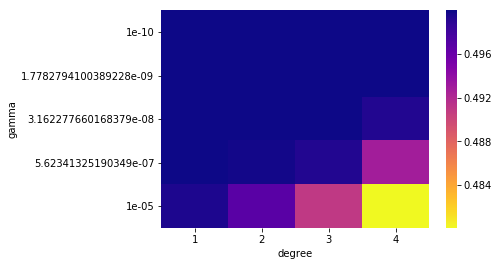

In [18]:
plot_heatmap(res, 'avg_mse_te', 'degree', 'gamma')